<font size=8> DynapSE2 NEURON TimeConstant Extraction


In [2]:
from pickle import TRUE
from pickletools import uint8
import time
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from venv import create

sys.path.append(os.getcwd() + '/..')

from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs.neuron_configs import neuron_configs

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression
from measure import meas_syn_tau
import numpy as np
import matplotlib.pyplot as plt

#from board_profile import main 
from adaptation import  ff_network, pc_pv_sst, pc_pv,pc_single,pv_single,ff_pc_pv,ff,sst_single,pc_pv_de
from configs.neuron_configs import neuron_configs

from adaptation_lib import tc_extraction,dynapse_setup,graphing,spike_stats
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt
import os

In [3]:
[board,profile_path,number_of_chips]=dynapse_setup.obtain_board()

<font size=6>Single Recording


<font size=6> Please record this one first to confirm, the osciloscope needs to record one first to settle

In [6]:

#set test parameters

core_to_measure=0
neuron_to_measure=12

#Initialization
model = board.get_model()
model.reset(ResetType.PowerCycle, (1 << number_of_chips) - 1)
time.sleep(1)
myConfig = model.get_configuration()
model.apply_configuration(myConfig)
time.sleep(1)

#Set up network
network = Network(config=myConfig, profile_path=profile_path, num_chips=number_of_chips)
input_neuron_1 = network.add_virtual_group(size=1)#normal input
input_neuron_2 = network.add_virtual_group(size=1)#normal input
input_neuron_3 = network.add_virtual_group(size=1)#normal input
input_neuron_4 = network.add_virtual_group(size=1)#normal input
test_neurons = network.add_group(chip=0, core=core_to_measure, size=255)

#set up latches$
set_dc_latches(config=myConfig, neurons=range(256), cores=[0,1,2], chips=range(number_of_chips))
model.apply_configuration(myConfig)
time.sleep(1)   

#Set neurons spiking threadholds to maximum 
neuron_config=neuron_configs()
set_configs(myConfig,model,neuron_config)
for c in range(4):
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_GAIN_N',1,150)
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_REFR_N',5,250)
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_SPKTHR_P',5,220)
    set_parameter(myConfig.chips[0].cores[c].parameters,"SOIF_DC_P", 0, 0)
model.apply_configuration(myConfig)
time.sleep(0.1)


#set neuron to monitor
myConfig.chips[0].cores[core_to_measure].neuron_monitoring_on = True
myConfig.chips[0].cores[core_to_measure].monitored_neuron =  neuron_to_measure
model.apply_configuration(myConfig)
time.sleep(0.1)




All configurations done!



In [12]:
leak_coarse=1
leak_fine=10
#SAVE
set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'SOIF_LEAK_N',leak_coarse,leak_fine)

[time_values_1,voltages_1]=tc_extraction.measure_pulse(myConfig,model,duration=2)
#recording_data_path = f'data/time_constant_recordings/{test_type}_test.npy'
#np.save(recording_data_path,[time_values_1,voltages_1])



All configurations done!



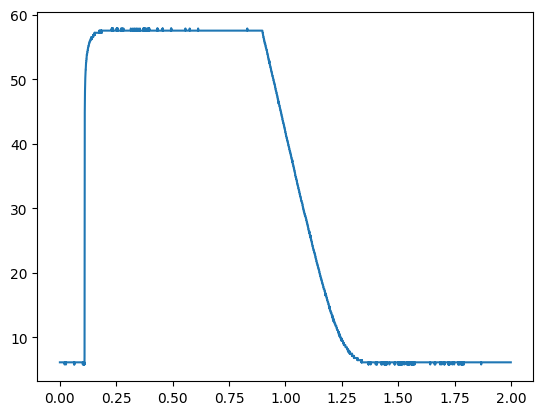

In [13]:
plt.plot(time_values_1,voltages_1)

In [ ]:


#pulse_decay_data_matrix=np.load('pulse_decay_data_Leak_0.npy',allow_pickle=True)
fig,ax=plt.subplots()
for i in range(len(pulse_decay_data_matrix)):
    ax.plot(pulse_decay_data_matrix[i][1],pulse_decay_data_matrix[i][0])    
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Pulse Decay')
plt.show()


<font size=6> Record Multiple Neurons 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from configs.neuron_configs import neuron_configs
neuron_config=neuron_configs()
#current neuron parameters for PC
neuron_config['neuron_to_measure']=20
neuron_config['core_to_measure']=1
neuron_config['neuron_to_measure']=20
#here I recorded all for one single coarse values
coarse_values=[1]
fine_values=np.arange(1,250,1,dtype=int)
pulse_decay_data_matrix=[]
for i in coarse_values:
    for j in fine_values:
        leak_parameter=[i,j]
        neuron_config['PC_LEAK']=leak_parameter
        pulse_decay_data=tc_extraction.pulse_osc_measurement(board,number_of_chips,neuron_config,duration=6) 
        pulse_decay_data_matrix.append(pulse_decay_data)



NameError: name 'tc_extraction' is not defined

In [ ]:
np.save('pulse_decay_data_matrix',pulse_decay_data_matrix)

In [ ]:
pulse_decay_data_matrix=np.load('pulse_decay_data_Leak_0.npy',allow_pickle=True)
fig,ax=plt.subplots()
for i in range(len(pulse_decay_data_matrix)):
    ax.plot(pulse_decay_data_matrix[i][1],pulse_decay_data_matrix[i][0])    
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Pulse Decay')
plt.show()


<font size=8> time constant extraction


In [10]:
neuron_config=neuron_configs()

neuron_config['PV_LEAK']=[1,60]
neuron_config['neuron_to_measure']=10
neuron_config['core_to_measure']=1
[voltage,time]=tc_extraction.pulse_osc_measurement(board,number_of_chips,neuron_config,duration=2.5) 
plt.plot(time,voltage)

Setting parameters

All configurations done!



KeyError: 'DC_pulse'

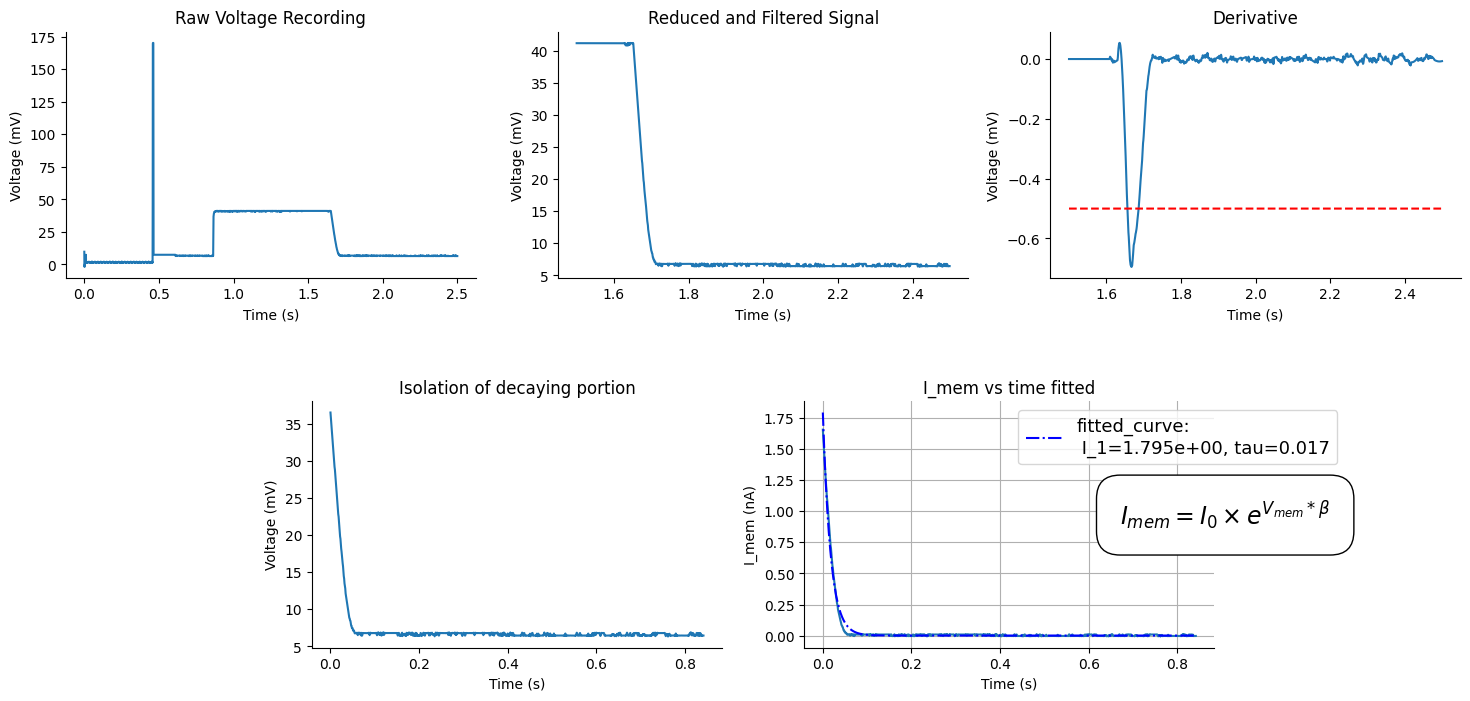

In [7]:
test_data=np.array([voltage,time])
time_constants.time_constant_extraction(test_data,full=True,beta=.75/26,cut_off=500)

<font size=8>Data Recording


In [20]:
coarse_value=1
core=1

#SET THE RANGES OF INTEREST 
if coarse_value ==0:
    duration=3
    leak_range = np.arange(10,256,10,dtype=int)
    neurons = np.arange(0,255,1,dtype=int)
if coarse_value >=1:
    duration=3
    neurons = np.arange(1,2,1,dtype=int)
    leak_range = np.arange(40,90,10,dtype=int)
#We shoudlnt be doing mroe than coarse value 1 for the neurons


In [15]:
import os
from configs.neuron_configs import neuron_configs
neuron_config = neuron_configs()
# current neuron parameters for PC

neuron_config['core_to_meausre'] = core

try:
    # Load previous data if exists
    recording_data_path = f'data/time_constant_recordings/pulse_data_core_{core}_coarse_{coarse_value}.npy'
    if os.path.exists(recording_data_path):
        pulse_decay_data_dict = np.load(recording_data_path, allow_pickle=True).item()
    else:
        pulse_decay_data_dict = {}
    # Iterate recording over neurons and leakage values
    for i in neurons:
        if i not in pulse_decay_data_dict:
            pulse_decay_data_dict[i] = {}
        for j in leak_range:
            if j not in pulse_decay_data_dict[i]:
                leak_parameter = [coarse_value,j]
                neuron_config['neuron_to_measure'] = i
                neuron_config['PC_LEAK'] = leak_parameter
                pulse_decay_data = time_constants.pulse_osc_measurement(board, number_of_chips, neuron_config, duration=duration)
                # Store the data with neuron id as the first key, and leakage value as the second key
                pulse_decay_data_dict[i][j] = pulse_decay_data
                # Save after each measurement
                np.save(recording_data_path, pulse_decay_data_dict)
finally:
    print('final_neuron recorded:',i)
    print('final_leak',j)

Setting parameters

All configurations done!

Setting parameters

All configurations done!

Setting parameters

All configurations done!

Setting parameters

All configurations done!

final_neuron recorded: 1
final_leak 80


<font size=8> Data Analysis


In [17]:
import os
import numpy as np
from adaptation.time_constants import time_constant_extraction
import matplotlib.pyplot as plt

recordings_data_path = f'data/time_constant_recordings/pulse_data_core_{core}_coarse_{coarse_value}.npy'

if os.path.exists(recordings_data_path):
    pulse_decay_data_dict = np.load(recordings_data_path, allow_pickle=True).item()
else:
    print('no data found')

time_constant_data_matrix = []

for i in neurons:
    if i in pulse_decay_data_dict and len(pulse_decay_data_dict[i]) >= len(leak_range)-1:
        print(i)
        neuron_time_constants = []
        for j in leak_range:
            time_constant = time_constant_extraction(pulse_decay_data_dict[i][j], full=False, beta=.75/26,cut_off=500) * 1000
            neuron_time_constants.append(time_constant)
        time_constant_data_matrix.append(neuron_time_constants)

time_constant_data_path = f'data/time_constant_recordings/pulse_tc_data_core_{core}_coarse_{coarse_value}_n.npz'
time_constant_data_matrix = np.array(time_constant_data_matrix)
mean_time_constants = np.mean(time_constant_data_matrix, axis=0)
std_time_constants = np.std(time_constant_data_matrix, axis=0)

# Save the time_constant_data_matrix, mean_time_constants,print(time_constant_data_matrix) and std_time_constants
np.savez(time_constant_data_path, time_constant_data_matrix=time_constant_data_matrix, mean_time_constants=mean_time_constants, std_time_constants=std_time_constants)

1


[[22.69065983 21.36918302 21.00752347 19.8048254  18.96731517 18.3340123
  17.28087834 17.16240463 16.63330737 16.09938422 15.72484415 15.02991626
  14.56470788 13.97957067 13.44510617 13.17612125 13.17634622 12.66779406
   8.41297022  8.50841285  8.46058891  8.42143145  8.43456232  8.43500839
   8.0615538 ]
 [23.18878736 22.4315003  21.34475737 20.38472911 19.78550706 19.25141772
  18.2548339  17.92454345 16.98274993 17.03212412 16.54835605 15.99780419
  14.75803565 14.50808775 14.31494884 13.87301227 13.67347866 13.15393376
  13.04403327 12.98892454 12.34884086  8.23770464  8.38560435  8.27694513
   8.35930231]
 [20.47233834 19.65622372 18.74936761 18.08947674 17.27280008 16.71548118
  16.25560973 15.70319914 15.45988993 14.71659097 14.28390835 13.91313429
  13.12035534 12.77593279 12.58009551 12.24875517 12.13678428 11.60285783
  11.65030943 11.28003867 11.08247662 10.6643435  10.58335124  7.10988387
   6.98845152]
 [23.7132195  22.89508905 22.00163611 21.26424909 20.36235506 19.341

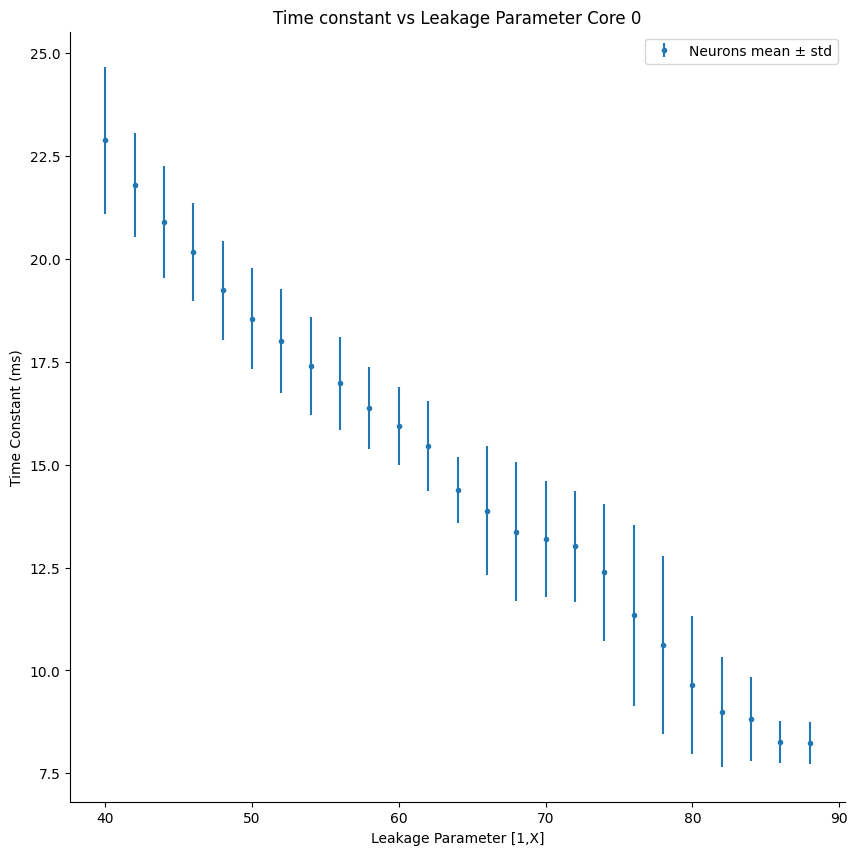

<font size=8> Plot various time constant extraction

In [170]:
import pandas as pd

# create a dictionary with your data
data_dict = {
    'Leakage Parameter': leak_range,
    'Mean Time Constants': mean_time_constants,
    'Standard Deviation': std_time_constants
}

# create the DataFrame
df = pd.DataFrame(data_dict)

# print the DataFrame
print(df)


    Leakage Parameter  Mean Time Constants  Standard Deviation
0                  40         7.754799e+01        1.197940e+02
1                  42        -1.778625e+05        3.977618e+05
2                  44         4.611554e+01        5.602542e+01
3                  46         8.328727e+01        1.409440e+02
4                  48         2.078946e+01        3.590221e+00
5                  50        -1.844501e+05        4.124841e+05
6                  52         1.254484e+02        2.405500e+02
7                  54         4.962748e+01        7.177815e+01
8                  56         1.433074e+02        2.833886e+02
9                  58         9.230609e+01        1.942902e+02
10                 60         2.261486e+00        4.221507e+01
11                 62         4.973294e+01        6.712109e+01
12                 64         1.740212e+02        3.510056e+02
13                 66         1.498437e+02        2.359795e+02
14                 68         4.511815e+01        9.096

In [ ]:
data=[time_constant_data_matrix[i] for i in range(2)]

fig, ax = plt.subplots()
ax.set_xlabel(f'Leakage Parameter [{coarse_value},2]')
ax.set_ylabel('Time Constant (ms)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set the labels for the x-ticks
# create the box plot
plt.boxplot(data)
#plt.violinplot(data)
plt.xticks([1, 2, 3], ['Core 0', 'Core 1', 'Core 2'])



# show the plot
plt.show()

In [ ]:
coarse_value=2
core=0

neurons = np.arange(0,255,1,dtype=int)
leak_range = np.arange(10,256,10,dtype=int)


if coarse_value == 2:
    leak_range = np.arange(5,121,5,dtype=int)

recordings_data_path = f'data/time_constant_recordings/pulse_data_core_{core}_coarse_{coarse_value}.npy'

if os.path.exists(recordings_data_path):
    pulse_decay_data_dict = np.load(recordings_data_path, allow_pickle=True).item()
else:
    print('no data found')

pulse_decay_data_dict[0][70][0]

for i in neurons:
    if i in pulse_decay_data_dict and len(pulse_decay_data_dict[i]) >= len(leak_range):
        plt.plot(pulse_decay_data_dict[i][70][1],pulse_decay_data_dict[i][70][0])
        plt.show()

<font size=8>Plot Various time Constant Extractions

In [ ]:
import os
import numpy as np
from adaptation.time_constants import time_constant_extraction
import matplotlib.pyplot as plt


recordings_data_path = f'data/time_constant_recordings/pulse_data_core_{core}_coarse_{coarse_value}.npy'

if os.path.exists(recordings_data_path):
    pulse_decay_data_dict = np.load(recordings_data_path, allow_pickle=True).item()
else:
    print('no data found')


for i in neurons:
    if i in pulse_decay_data_dict and len(pulse_decay_data_dict[i]) >= len(leak_range)-1:
        for j in leak_range:
            time_constant = time_constant_extraction(pulse_decay_data_dict[i][j], full=True, beta=.75/26,cut_off=500)



<font size=8>compare with Rockpool


In [ ]:
import rockpool
from rockpool.devices.dynapse import DynapSimCore

core_rock = DynapSimCore.from_specification(tau_mem=20e-3)
print(core.time)
print(core.Itau_mem)
print(core.export_Dynapse2Parameters()["SOIF_LEAK_N"])

core_rock = DynapSimCore.from_specification(tau_mem=5e-3)
print(core.time)
print(core.Itau_mem)
print(core.export_Dynapse2Parameters()["SOIF_LEAK_N"])

core_rock = DynapSimCore.from_specification(tau_mem=100e-3)
print(core.time)
print(core.Itau_mem)
print(core.export_Dynapse2Parameters()["SOIF_LEAK_N"])

core_rock = DynapSimCore.from_specification(tau_ampa=5e-3)
print(core.time)
print(core.Itau_ampa)
print(core.export_Dynapse2Parameters()["SOIF_LEAK_N"])


In [ ]:
np.arange(0,251,10,dtype=int)
